# Важно: оценка в дереве теперь только по $\nu$ !

In [1]:
import json
import time
import glob
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.polynomial.chebyshev as cheb
from scipy.stats import moment
from multiprocessing.pool import Pool, ThreadPool
from itertools import permutations
from ipywidgets import IntProgress
from IPython.display import display
from IPython.display import clear_output
from scipy.interpolate import lagrange
import matplotlib.pyplot as plt
from IPython.display import display as pbdisplay
import pandas as pd

#%matplotlib inline

import shutil
import sys
import os.path

from pyomo.environ import *
from pyomo.gdp import *

from pyomo.environ import *
from pyomo.gdp import *

In [23]:
timeout = 5
LAMBDA = 0.01
MU = 100
SIGMA = 40
VARK = 1

def r(task):
    ind = 0
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def p(task):
    ind = 1
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def d(task):
    ind = 2
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def remove(arr, elem):
    return np.delete(arr, np.where(np.in1d(arr, elem)))

class TaskSet:
    
    def __init__(self, a):
        if isinstance(a, int):
            rs = np.random.uniform(0, 100, size=(a,))
            ps = np.random.uniform(0, 100, size=(a,))
            ds = np.random.uniform(0, 100, size=(a,))
            self.array = np.array([rs, ps, ds]).T.astype(float)
        else:
            self.array = np.copy(a)
            
    def __repr__(self):
        return "  r  |  p  |  d  \n" + str(self.array)
    
    def copy(self):
        return TaskSet(self.array)
    
    def __getitem__(self, key):
        return TaskSet(self.array[key])
    
    def __iter__(self):
        return iter(self.array)
    
    def C(self, i, tau=0):
        t = tau
        for task in self.array[:i+1]:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def C_max(self, tau=0):
        t = tau
        for task in self.array:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def L(self, i=None, tau=0):
        if i is None:
            return self.C_max(tau) - d(self[-1])
        return self.C(i, tau) - d(self[i])
    
    def L_max(self, tau=0):
        if len(self) == 0: return float('inf')
        return max([self.L(i, tau) for i, _ in enumerate(self)])
    
    def T(self, i=None, tau=0):
        return max(0, self.L(i, tau))
    
    def T_max(self, tau=0):
        return max(0, self.L_max(tau))
    
    def __len__(self):
        return len(self.array)
    
    def __eq__(self, other):
        return self.array == other
    
    def without(self, indexes):
        return TaskSet(np.delete(self.array, np.array(indexes).astype(float), axis=0))
    
    def find(self, item):
        return np.where((self.array == item).all(axis=1))[0]
    
    def transpose(self):
        return self.array.T
    
    def scale_r(self, alpha):
        self.array[:,0] = self.array[:,0]*alpha
        return self
    
    def scale(self, alpha, key='r'):
        if key == 'r': ind = 0
        elif key == 'p': ind = 1
        else: ind = 2
        self.array[:,ind] = self.array[:,ind]*alpha
        return self
    
def dual(N, tau, B):
    if len(N.without(B)) == 0: return float('inf')
    pi_r = r(np.argsort(N, axis=0).transpose())
    bestL = N[pi_r].L(tau=tau)
    for i_k in pi_r:
        toDrop = B.copy()
        toDrop.append(i_k)
        #print(toDrop)
        s = N.without(toDrop)
        #print(s)
        if len(s) != 0:
            task_l = min(s, key=r)
            i_l = N.find(task_l)[0]
            pi_k = remove(pi_r, [i_l, i_k])
            pi_k = np.insert(pi_k, 0, i_l)
            pi_k = np.append(pi_k, i_k)
            L_k = N[pi_k].L(tau=tau)
            if L_k < bestL:
                bestL = L_k
    additionalL = N[pi_r].L(i=0, tau=tau)
    if additionalL > bestL:
        bestL = additionalL
    return bestL

class Instance:
    
    def __init__(self, N, tau=0, pi=[], B=[]):
        self.N = N.copy()
        self.tau = tau
        self.pi = pi.copy()
        self.B = B.copy()
        self.nu = dual(N, tau, B)
        
    def __getitem__(self, key):
        return TaskSet(self.N.array[key])
        
    def best_job(self):
        s = self.N.without(self.B)
        sn = s[r(s.transpose()) <= self.tau]
        if len(sn) == 0:
            f = min(s, key=r)
            #self.tau = r(f)
            #self.nu = dual(self.N, self.tau, self.B)
        else:
            f = min(sn, key=d)
        return self.N.find(f)[0]
    
    def L(self, i=None):
        return self[self.pi].L(i, self.tau)
    
    def T(self, i=None):
        return self[self.pi].T(i, self.tau)
        
    def L_max(self):
        return self[self.pi].L_max(self.tau)
    
    def T_max(self):
        return self[self.pi].T_max(self.tau)
    
    def __repr__(self):
        return "Instance:\n" + repr(self.N) + "\nnu  = " + str(self.nu) + "\ntau = " + str(self.tau) + "\npi  = " + str(self.pi) + "\nB   = " + str(self.B)
    
    
def main(N, tau=0, verbose=False, modified=False):
    tb = time.time()
    b_counter = 0
    #print("bi")
    instances = [Instance(N, tau)]
    #print("ai")
    if modified: bestPi = list(range(len(N)))
    else: bestPi = []
    while len(instances) > 0:
        ti = time.time()
        if ti - tb > timeout:
            return TaskSet([]), -1
        bestInstanceIndex, bestInstance = min(enumerate(instances), key=lambda x: x[1].nu) # + N[x[1].pi].L_max(tau))
        instances.pop(bestInstanceIndex)
        f = bestInstance.best_job()
        f_data = bestInstance[f]
        N1 = bestInstance.N.without(f)
        tau1 = max(r(f_data), bestInstance.tau) + p(f_data)
        B1 = []
        pi1 = bestInstance.pi.copy()
        pi1.append(N.find(f_data)[0])
        i1 = Instance(N1, tau1, pi1, B1)
        N2 = bestInstance.N
        tau2 = bestInstance.tau
        B2 = bestInstance.B.copy()
        B2.append(N2.find(f_data)[0]) #!
        pi2 = bestInstance.pi
        i2 = Instance(N2, tau2, pi2, B2)
        instances += [i1, i2]
        b_counter += 1
        #print(i1)
        if len(pi1) == len(N):
            #print(N[bestPi].L_max(tau))
            #print(pi1)
            if N[pi1].L_max(tau) < N[bestPi].L_max(tau):
                bestPi = pi1.copy()
                if verbose: print(bestPi, '\tLmax =', N[bestPi].L_max(tau))
        #lb = len(instances)
        instances = [i for i in instances if i.nu < N[bestPi].L_max(tau)]
        #print(lb, len(instances))
    return bestPi, b_counter
        
def bruteforce(N, tau=0):
    best_L = N.L_max(tau)
    best_N = N.copy()
    for perm in permutations(N):
        s = TaskSet(perm)
        L = s.L_max(tau)
        if L < best_L:
            best_L = L
            best_N = s.copy()
    return best_L, best_N

def generate_instances(N_TASKS, N_JOBS, fname='data.pickle'):
    tasks = []
    for i in range(N_TASKS):
        s = TaskSet(N_JOBS)
        tasks.append(s)

    with open(fname, 'wb') as f:
        pickle.dump(tasks, f)
        
def parse_instances(fname='data.pickle'):
    with open(fname, 'rb') as f:
        tasks = pickle.load(f)
    return tasks

def lagrange_interpolation(key, s):
    orig_s = s.copy()
    this_scheds = []
    alphaRange = np.arange(0, 2.1, 0.2)
    scaledSchedules = []
    for alpha in alphaRange:
        scaledSchedules.append(s.copy().scale(alpha, key=key))
    flattenedScaledSchedules = list(map(lambda x: x.array.flatten(), scaledSchedules))

    #print("\rCurrently working with", n)
    approxResults = []
    if len(alphaRange) != len(scaledSchedules): raise RuntimeError()
    for i, a in enumerate(alphaRange):
        if a != 1:
            s = scaledSchedules[i]
            sched, count = main(s, verbose=False)
            if count == -1: continue
            this_scheds.append(sched)
            if sched != this_scheds[-1]:
                if orig_s[sched].L_max() != orig_s[this_scheds[-1]].L_max():
                    print("Schedules non-equivalent!")
                    raise Exception()
            Lmax = s[sched].L_max()
            approxResults.append((a, Lmax))
    approxResults = np.array(approxResults)
    x = approxResults[:,0]
    y = approxResults[:,1]
    #print(len(x))
    #print(x, y)
    poly = lagrange(x, y)
    return poly(1.), this_scheds

def simplex(s, verbose=True):
    JOBS = s.array.copy()

    t = dict()
    for i, j in enumerate(JOBS):
        t[str(i)] = {'r': j[0], 'p': j[1], 'd': j[2]}

    JOBS = t
    if verbose: print(JOBS)


    def opt_schedule(JOBS):

        # create model
        m = ConcreteModel()

        # index set to simplify notation
        m.J = Set(initialize=JOBS.keys())
        m.PAIRS = Set(initialize = m.J * m.J, dimen=2, filter=lambda m, j, k : j < k)

        # upper bounds on how long it would take to process all jobs
        tmax = max([JOBS[j]['r'] for j in m.J]) + sum([JOBS[j]['p'] for j in m.J])

        # decision variables
        m.start      = Var(m.J, domain=NonNegativeReals, bounds=(0, tmax))
        m.pastdue    = Var(m.J, domain=NonNegativeReals, bounds=(0, tmax))
        m.early      = Var(m.J, domain=NonNegativeReals, bounds=(0, tmax))
        #m.x = Var(domain=NonNegativeReals, bounds=(0, tmax))
        # additional decision variables for use in the objecive
        m.makespan   = Var(domain=NonNegativeReals, bounds=(0, tmax))
        m.maxpastdue = Var(domain=NonNegativeReals, bounds=(0, tmax), initialize=tmax)
        m.ispastdue  = Var(m.J, domain=Binary)

        # objective function
        #m.OBJ = Objective(expr = sum([m.pastdue[j] for j in m.J]), sense = minimize)
        m.OBJ = Objective(rule= lambda md: md.maxpastdue, sense = minimize)

        # constraints
        #m.c0 = Constraint(m.x == m.maxpastdue)
        m.c1 = Constraint(m.J, rule=lambda m, j: m.start[j] >= JOBS[j]['r'])
        m.c2 = Constraint(m.J, rule=lambda m, j: 
                m.start[j] + JOBS[j]['p'] + m.early[j] == JOBS[j]['d'] + m.pastdue[j])
        m.c3 = Disjunction(m.PAIRS, rule=lambda m, j, k:
            [m.start[j] + JOBS[j]['p'] <= m.start[k], 
             m.start[k] + JOBS[k]['p'] <= m.start[j]])    

        m.c4 = Constraint(m.J, rule=lambda m, j: m.pastdue[j] <= m.maxpastdue)
        m.c5 = Constraint(m.J, rule=lambda m, j: m.start[j] + JOBS[j]['p'] <= m.makespan)
        m.c6 = Constraint(m.J, rule=lambda m, j: m.pastdue[j] <= tmax*m.ispastdue[j])

        TransformationFactory('gdp.hull').apply_to(m)
        if verbose:
            SolverFactory('glpk').solve(m).write()
        else:
            SolverFactory('glpk').solve(m)

        SCHEDULE = {}
        for j in m.J:
            SCHEDULE[j] = {'machine': 1, 'start': m.start[j](), 'finish': m.start[j]() + JOBS[j]['p']}

        if verbose: print(SCHEDULE)
        return SCHEDULE

    SCHEDULE = opt_schedule(JOBS)
    pi = list(map(int, sorted(SCHEDULE, key=lambda x: SCHEDULE[x]['start'])))
    return pi

def scale_timing(N_POINTS, FACTOR_MAX, N_TASKS, method='dual'):
    """
    Available methods: dual, simplex
    """
    pBar = IntProgress(min=0, max=N_POINTS**2, step=1)
    pbdisplay(pBar)
    results = np.zeros((N_POINTS, N_POINTS))
    for n in range(N_TASKS):
        pBar.value = 0
        times = np.zeros((N_POINTS, N_POINTS))
        s = tasks[n]
        for factor_r in range(N_POINTS):
            for factor_d in range(N_POINTS):
                pBar.value += 1
                scaled_s = s.copy().scale(FACTOR_MAX*factor_r/N_POINTS, key='r').scale(FACTOR_MAX*factor_d/N_POINTS, key='d')
                tb = time.time()
                if method == 'dual':
                    sched, count = main(s)
                elif method == 'simplex':
                    sched = simplex(s, verbose=False)
                times[factor_r, factor_d] = time.time() - tb
        results = results + times
    results = results / N_TASKS
    return results

def heatmap(z, N_POINTS, FACTOR_MAX, N_TASKS, method='dual'):
    y, x = np.meshgrid(np.linspace(0, FACTOR_MAX, N_POINTS), np.linspace(0, FACTOR_MAX, N_POINTS))
    #print(x.shape, y.shape, z.shape)
    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    z = z[:-1, :-1]
    z_min, z_max = np.abs(z).min(), np.abs(z).max()

    fig, ax = plt.subplots(figsize=(8,6))

    c = ax.pcolormesh(x, y, z, cmap='Blues', vmin=z_min, vmax=z_max)
    #ax.set_title('pcolormesh')
    # set the limits of the plot to the limits of the data
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    ax.set_xlabel('α')
    ax.set_ylabel('γ')
    ax.set_title("%s tasks and %s*%s points with %s method" % (N_TASKS, N_POINTS, N_POINTS, method))
    fig.colorbar(c, ax=ax)

    plt.show()
    
def plot_heatmap(N_POINTS=15, FACTOR_MAX=1000, N_TASKS=5, method='dual'):
    z = scale_timing(N_POINTS, FACTOR_MAX, N_TASKS, method)
    heatmap(z, N_POINTS, FACTOR_MAX, N_TASKS, method)
    fname = "%spoints%smax%stasks%smethod.json" % (N_POINTS, FACTOR_MAX, N_TASKS, method)
    with open(fname, 'w') as f:
        json.dump(z.tolist(), f)

In [4]:
generate_instances(50, N_JOBS=10, fname='10data.pickle')

In [5]:
tasks = parse_instances(fname='10data.pickle')

In [7]:
tasks[49]

  r  |  p  |  d  
[[62.31123258 56.02910627 87.46467405]
 [82.97135311 20.76932056 12.79093153]
 [ 6.40559488 90.33090343 80.34180652]
 [48.63146608 33.52977237 10.97909956]
 [72.3013808  45.99804106 20.27806512]
 [91.73245233 73.20230593 24.00435524]
 [54.48970076 90.66917133 43.28628308]
 [22.98812694 25.44708417 50.35110781]
 [34.09171074 71.36684319 30.68589423]
 [85.72140075 89.30613755 78.56661554]]

# Проверяем корректность двойственного алгоритма

In [22]:
pBar = IntProgress(min=0, max=len(tasks))
pbdisplay(pBar)
for s in tasks:
    pBar.value += 1
    pi, count = main(s)
    mainL = s[pi].L_max()
    bruteL, brutePi = bruteforce(s)
    #print(mainL, bruteL)
    if not np.isclose(mainL, bruteL):
        print(mainL, bruteL)
        raise RuntimeError()

IntProgress(value=0, max=250)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


# Сравниваем множества оптимальных расписаний

In [12]:
pBar = IntProgress(min=0, max=len(tasks))
pbdisplay(pBar)
for t in tasks[1:2]:
    print(lagrange_interpolation('r', t))
    pBar.value += 1

IntProgress(value=0, max=250)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


(261.41991041046447, [[1, 4, 3, 2, 0], [4, 1, 3, 2, 0], [4, 1, 3, 2, 0], [4, 1, 3, 2, 0], [4, 1, 3, 2, 0], [4, 1, 3, 2, 0], [4, 1, 3, 2, 0], [4, 3, 1, 2, 0], [4, 3, 1, 2, 0], [4, 3, 1, 2, 0]])


In [44]:
pBar = IntProgress(min=0, max=len(tasks))
display(pBar)
for t in tasks:
    lagrange_interpolation('p', t)
    pBar.value += 1

IntProgress(value=0, max=250)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


In [45]:
pBar = IntProgress(min=0, max=len(tasks))
display(pBar)
for t in tasks:
    lagrange_interpolation('d', t)
    pBar.value += 1

IntProgress(value=0, max=250)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


# Simplex

In [97]:
#s = TaskSet(9)
simplex(s, verbose=True)

{'0': {'r': 57.84052038967867, 'p': 48.62548109452911, 'd': 93.51630894561383}, '1': {'r': 58.02077240832539, 'p': 54.105147234783566, 'd': 27.99199940800714}, '2': {'r': 93.68350120521268, 'p': 72.85105518764205, 'd': 14.308960014291417}, '3': {'r': 5.354785398604756, 'p': 24.592898610393178, 'd': 23.829382173459702}, '4': {'r': 69.62455879642633, 'p': 25.18631657048963, 'd': 83.50919482815111}, '5': {'r': 60.25875522188513, 'p': 7.540055283040092, 'd': 79.30620181689049}, '6': {'r': 17.793690038456834, 'p': 66.30379358161986, 'd': 94.63355660939563}, '7': {'r': 75.22677628559701, 'p': 31.001474016758667, 'd': 1.0505351818713038}, '8': {'r': 73.55947561495465, 'p': 0.019463971088828913, 'd': 57.81566652654626}}
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# --------

[3, 6, 8, 7, 1, 2, 5, 4, 0]

IntProgress(value=0, max=625)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


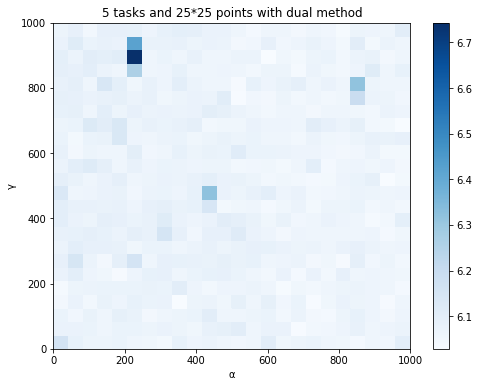

AttributeError: 'str' object has no attribute 'write'

In [21]:
plot_heatmap(N_POINTS=25, FACTOR_MAX=1000, N_TASKS=5, method='dual')

IntProgress(value=0, max=400)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


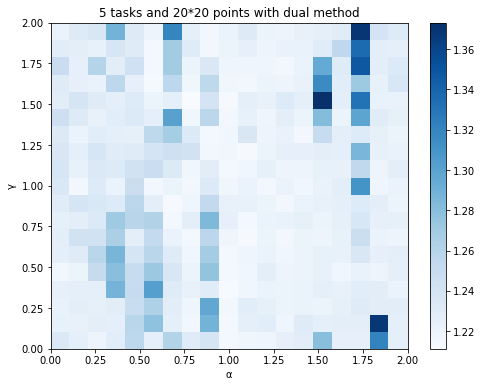

In [24]:
plot_heatmap(N_POINTS=20, FACTOR_MAX=2, N_TASKS=5, method='dual')

IntProgress(value=0, max=225)

IntProgress(value=0, max=225)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


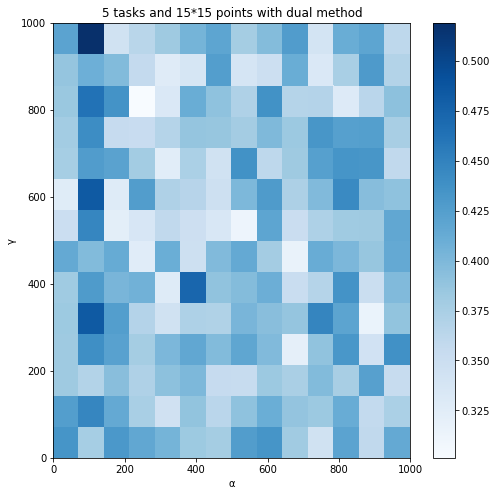

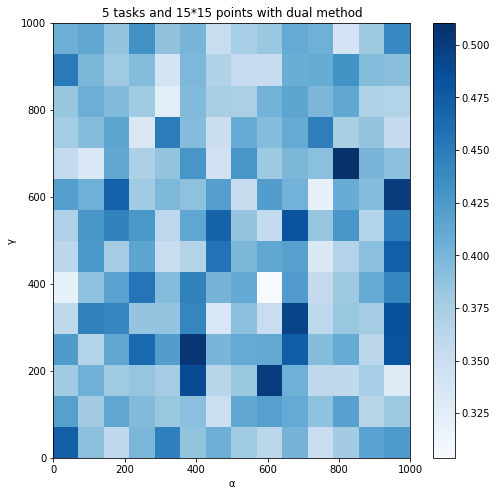

OSError: [Errno 22] Invalid argument: '10 tasks and 2*1 points with dual method'

In [19]:
arguments = [(10, 2, 1), (10, 1000, 1)]
with ThreadPool(processes=len(arguments)) as pool:
    pool.starmap(plot_heatmap, arguments)

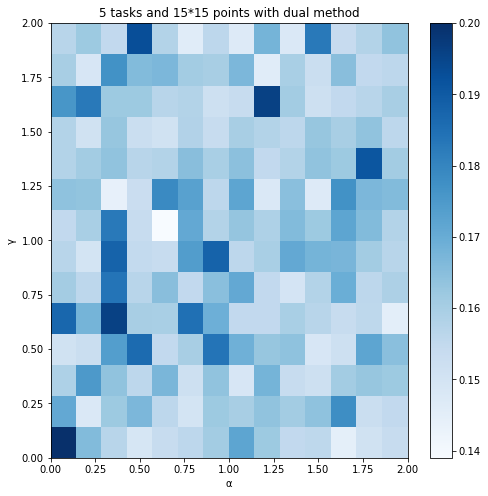

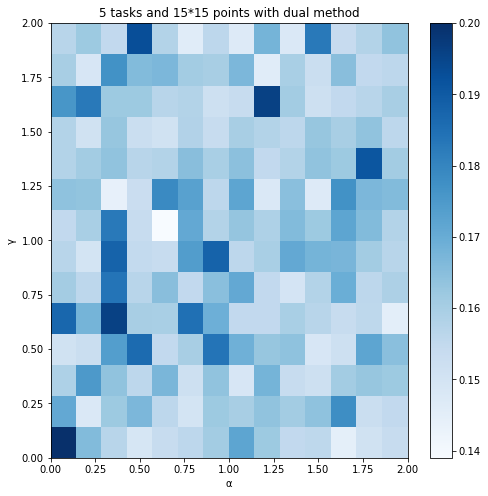

In [86]:
#z = scale_timing(N_POINTS=15, FACTOR_MAX=2, N_TASKS=5, method='dual')
heatmap(z, N_POINTS=15, FACTOR_MAX=2, N_TASKS=5)
heatmap(z, N_POINTS=15, FACTOR_MAX=2, N_TASKS=5)

IntProgress(value=0, max=225)

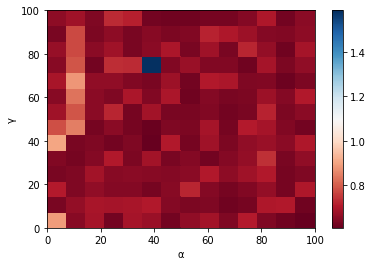

In [58]:
z = scale_timing(N_POINTS=15, FACTOR_MAX=1000, N_TASKS=5, method='simplex')
heatmap(z, N_POINTS=15, FACTOR_MAX=1000, N_TASKS=5)

IntProgress(value=0, max=225)

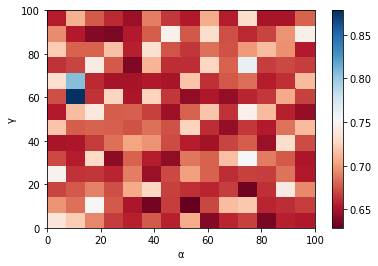

In [59]:
z = scale_timing(N_POINTS=15, FACTOR_MAX=2, N_TASKS=5, method='simplex')
heatmap(z, N_POINTS=15, FACTOR_MAX=2, N_TASKS=5)